In [1]:
import os
import sys
import h5py
import pickle
import subprocess
import numpy as np
from time import time
from tqdm import tqdm
from functools import partial
from operator import itemgetter
import matplotlib.pyplot as plt
from multiprocessing import Process
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

import keras
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, LSTM, BatchNormalization
from keras.models import Model, load_model

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
sys.path.append('..')

In [3]:
from modis_utils.misc import cache_data, restore_data

In [4]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL_1.dat'))

In [5]:
for x in data:
    print(x.shape)

(598, 1657, 2)
(92, 1657, 2)


In [6]:
train_boundary_vectors = data[0]
test_boundary_vectors = data[1]

In [7]:
train_boundary_vectors.shape, test_boundary_vectors.shape

((598, 1657, 2), (92, 1657, 2))

In [8]:
n_points = train_boundary_vectors.shape[1]

In [9]:
n_years = len(train_boundary_vectors)//46
n_years

13

In [10]:
'''
data_train = train_boundary_vectors[:0].copy()
data_test = test_boundary_vectors
for i in range(n_years):
    year = 2003 + i
    if year != 2011 and year != 2013:
        data_train = np.vstack([data_train, train_boundary_vectors[i*46 : (i + 1)*46]])
print(data_train.shape)
'''

'\ndata_train = train_boundary_vectors[:0].copy()\ndata_test = test_boundary_vectors\nfor i in range(n_years):\n    year = 2003 + i\n    if year != 2011 and year != 2013:\n        data_train = np.vstack([data_train, train_boundary_vectors[i*46 : (i + 1)*46]])\nprint(data_train.shape)\n'

In [11]:
data_train = train_boundary_vectors
data_test = test_boundary_vectors

In [12]:
data_train_1 = data_train.reshape(data_train.shape[0], -1)
data_train_1.shape

(598, 3314)

In [13]:
data_test_1 = data_test.reshape(data_test.shape[0], -1)

In [14]:
variants = []
for i in range(data_train_1.shape[1]):
    var = np.var(data_train_1[:, i])
    variants.append(var)

In [15]:
variants_1 = variants.copy()

In [16]:
variants_2 = np.asarray(variants_1)
variants_2

array([ 0.        , 16.40228018,  0.        , ..., 16.31268386,
        0.        , 17.84837977])

In [17]:
list_idx = np.where(variants_2 > 1)[0]

In [18]:
len(list_idx)

2311

In [19]:
data_train_2 = data_train_1[:, list_idx]
data_train_2.shape

(598, 2311)

In [20]:
data_test_2 = data_test_1[:, list_idx]
data_test_2.shape

(92, 2311)

In [21]:
scaler = MinMaxScaler()
scaler.fit(data_train_2)

/home/anhkhoa/anaconda3/envs/pytf/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
data_train_3 = scaler.transform(data_train_2)
data_test_3 = scaler.transform(data_test_2)

In [23]:
def create_sequence_data(data_train, data_test, timesteps=47):
    data_all = np.vstack([data_train, data_test])
    len_val = 46
    len_train = len(data_train) - timesteps - len_val
    len_test = len(data_test)
    
    train_X = []
    train_y = []
    val_X = []
    val_y = []
    test_X = []
    test_y = []
    
    for i in range(timesteps, timesteps + len_train):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        train_X.append(X)
        train_y.append(y)
        
    for i in range(timesteps + len_train, timesteps + len_train + len_val):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        val_X.append(X)
        val_y.append(y)
        
    for i in range(timesteps + len_train + len_val, timesteps + len_train + len_val + len_test):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        test_X.append(X)
        test_y.append(y)
        
    return np.vstack(train_X), np.vstack(train_y), np.vstack(val_X), np.vstack(val_y), np.vstack(test_X), np.vstack(test_y)

In [24]:
train_X, train_y, val_X, val_y, test_X, test_y = create_sequence_data(data_train_3, data_test_3)

In [25]:
data = {}
data['train_X'] = train_X
data['train_y'] = train_y
data['val_X'] = val_X
data['val_y'] = val_y
data['test_X'] = test_X
data['test_y'] = test_y

In [26]:
for k, v in data.items():
    print(v.min(), v.max())

0.0 1.0000000000000142
0.0 1.0000000000000142
0.0 1.0000000000000142
0.0 1.0000000000000142
0.0 1.0000000000000142
0.0 1.0000000000000142


In [27]:
data['train_X'].shape

(505, 47, 2311)

In [28]:
def save_data_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

def load_data_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def create_empty_list(n):
    res = []
    for _ in range(n):
        res.append(None)
    return res

def mse(x, y):
    return np.mean((x - y)**2)

In [29]:
training_fig_dir = 'visualize/lstm_2/training'
if not os.path.exists(training_fig_dir):
    os.makedirs(training_fig_dir)

In [30]:
'''
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()
'''

"\nfrom tensorflow.python.client import device_lib\n\ndef get_available_gpus():\n    local_device_protos = device_lib.list_local_devices()\n    return [x.name for x in local_device_protos if x.device_type == 'GPU']\nget_available_gpus()\n"

In [31]:
inference_dir = 'inference'
if not os.path.exists(inference_dir):
    os.makedir(inference_dir)

In [32]:
def train(gpu_id, data_path, epochs, batch_size, timesteps, units, n, model_dir, training_fig_dir):
    subprocess.call(['python', 'lstm_train.py', 
                     str(gpu_id), data_path, str(epochs), str(batch_size), 
                     str(timesteps), str(units), str(n), model_dir, training_fig_dir])

def inference(gpu_id, input_path, batch_size, steps, model_paths_path, n):
    subprocess.call(['python', 'lstm_inference.py', 
                     str(gpu_id), input_path, str(batch_size), str(steps), model_paths_path, str(n)])

class LSTM_2:

    def __init__(self, data, data_train_full, list_idx=None, scaler=None, mode='train'):
        self.model_dir = 'lstm'
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        
        self.mode = mode
        self.model = None
        self.n_cores = 4
        
        self.data = data
        
        self.units = data['train_X'].shape[2]
        self.timesteps = data['train_X'].shape[1]
        self.full_shape = data_train_full.shape[-1]
        
        if list_idx is None:
            self.list_idx = np.arange(self.full_shape)
        self.list_idx = list_idx

        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            
        if self.mode == 'inference':
            self.model_paths = self.load_model(self.model_dir)
            
        self.list_small_variant_idx = np.setdiff1d(np.arange(self.full_shape), self.list_idx)
        self.default_values = {}
        for i in self.list_small_variant_idx:
            mean_value = np.mean(data_train_full[:, i])
            self.default_values[i] = int(mean_value)
            
        self.scaler = scaler
        self.model_paths = None
        
    def load_model(self, model_dir=None):
        if model_dir is None:
            model_dir=self.model_dir
        self.model_paths = {}
        for i in range(len(self.list_idx)):
            self.model_paths[i] = os.path.join(model_dir, '{}.dat'.format(i))
        return self.model_paths
    
    def train(self, epochs=1, batch_size=32):
        if not os.path.exists('tmp'):
            os.makedirs('tmp')
        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
        cache_data(self.data, 'tmp/data.dat')
        processes = []
        for gpu_id in range(4):
            p = Process(target=train, args=(gpu_id, 'tmp/data.dat', epochs, batch_size,
                                            self.timesteps, 1, len(self.list_idx),
                                            self.model_dir, training_fig_dir))
            processes.append(p)
        for p in processes:
            p.start()
        for p in processes:
            p.join()
        self.model_paths = self.load_model()
        return self.model_paths
    
    def inference(self, input_test, return_full=None, return_original_range=False):
        res = self.inference_multisteps(input_test, 1, return_full, return_original_range)
    
    def _inverse_transform(self, x):
        shape = x.shape
        x = x.reshape(-1, shape[-1])
        x = self.scaler.inverse_transform(x)
        return x.reshape(shape)
    
    def _predict_multisteps(self, input_test, steps, batch_size=128):
        if not os.path.exists('tmp'):
            os.makedirs('tmp')
        cache_data(input_test, 'tmp/input_test.dat')
        cache_data(self.model_paths, 'tmp/model_paths.dat')
        processes = []
        for gpu_id in range(4):
            p = Process(target=inference, args=(gpu_id, 'tmp/input_test.dat', batch_size,
                                                steps, 'tmp/model_paths.dat', len(self.list_idx)))
            processes.append(p)
        for p in processes:
            p.start()
        for p in processes:
            p.join()
        
        res = []
        for i in range(4):
            res += restore_data('tmp/out_{}.dat'.format(i))
        return np.concatenate(res, axis=-1)
    
    def inference_multisteps(self, input_test, steps=1, return_full=None, return_original_range=False):
        if self.model is None:
            self.model = self.load_model()
        if len(input_test.shape) == 2:
            input_test = np.expand_dims(input_test, axis=0)
        inferences = self._predict_multisteps(input_test, batch_size=64, steps=steps)
        if return_full:
            inferences = self._inverse_transform(inferences)
            #inferences = (92x80x2285)
            outputs = np.zeros((inferences.shape[:-1] + (self.full_shape,)))
            for i, idx in enumerate(self.list_idx):
                outputs[:, :, idx] = inferences[:, :, i]
            for idx, default_value in self.default_values.items():
                outputs[:, :, idx] = default_value
            return outputs
        if return_original_range:
            inferences = self._inverse_transform(inferences)
        return inferences

    def eval(self, inputs=None, groundtruths=None, return_original_range=False):
        if inputs is None:
            inputs = self.data['test_X']
        if groundtruths is None:
            groundtruths = self.data['test_y']
        groundtruth_shape = groundtruths.shape[-1]
        return_full = (groundtruth_shape == self.full_shape)
        predictions = self.inference(inputs, return_full, return_original_range)
        if return_original_range:
            groundtruths = self.scaler.inverse_transform(groundtruths)
        
        loss = (groundtruths - predictions)**2
        return loss, predictions

In [33]:
lstm_2 = LSTM_2(data, data_train_1, list_idx, scaler, mode='train')
model_path = lstm_2.train(epochs=30, batch_size=512)

In [34]:
lstm_2 = LSTM_2(data, data_train_1, list_idx, scaler, mode='inference')
full_shape_predictions_multi_steps = lstm_2.inference_multisteps(data['test_X'], 80, return_full=True)
cache_data(full_shape_predictions_multi_steps, os.path.join(inference_dir, 'lstm_2_80_multisteps.dat'))

In [35]:
full_shape_predictions_multi_steps = restore_data(os.path.join(inference_dir, 'lstm_2_80_multisteps.dat'))
full_shape_predictions_multi_steps.shape

(92, 80, 3314)

In [36]:
data_test_1.shape

(92, 3314)

In [37]:
predictions = full_shape_predictions_multi_steps[:, 0, :]
losses = mse(data_test_1, predictions)
print(losses)
print(losses.mean())

90.73733621340644
90.73733621340644


In [38]:
def reshape_to_point(x):
    return x.reshape(x.shape[0], -1, 2)

In [39]:
full_shape_predictions_multi_steps_0 = reshape_to_point(full_shape_predictions_multi_steps[0, :, :])
full_shape_predictions_multi_steps_0.shape

(80, 1657, 2)

In [40]:
def convert_boundaries_to_image(boundary, img_width, img_height):
    img = np.zeros((img_width, img_height))
    for i in range(boundary.shape[0]):
        x = boundary[i][0].astype(np.int32)
        y = boundary[i][1].astype(np.int32)
        img[x, y] = 1
    return img

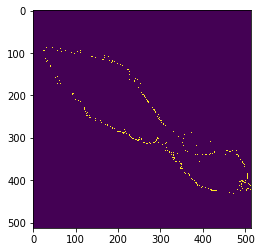

In [41]:
img1 = convert_boundaries_to_image(full_shape_predictions_multi_steps_0[0], 513, 513)
plt.imshow(img1)

# Calculate Polygon area

In [42]:
full_shape_predictions_multi_steps.shape, data_test.shape

((92, 80, 3314), (92, 1657, 2))

In [43]:
def find_border(data_points):
    x = data_points[:, 0]
    y = data_points[:, 1]
    return x.min(), y.min(), x.max(), y.max()

class Line:
    def __init__(self, x1, y1, x2, y2):
        self.a = y1 - y2
        self.b = x2 - x1
        self.c = x1*y2 - x2*y1
    def calc(self, x, y):
        return self.a*x + self.b*y + self.c
    
def convert_boundary_vector_to_polygon(boundary_vector):
    x1, y1, x2, y2 = find_border(boundary_vector)
    line = Line(x1, y1, x2, y2)
    score_point = [line.calc(x, y) for x, y in boundary_vector]
    group_1 = []
    group_2 = []
    for i, p in enumerate(boundary_vector):
        if score_point[i] < 0:
            group_1.append(p)
        else:
            group_2.append(p)
    group_1 = sorted(group_1, key=itemgetter(0,1))
    group_2 = sorted(group_2, key=itemgetter(0,1), reverse=True)
    group = np.vstack([group_1, group_2])
    return Polygon(zip(group[:, 0], group[:, 1]))

region = [(10, 10), (200, 10), (512, 400), (512, 512), (300, 512), (10, 100), (10, 10)]

def check_point_in_region(p, lines, sample_scores):
    for line, sample_score in zip(lines, sample_scores):
        score = line.calc(p[0], p[1])
        if score/sample_score < 0:
            return False
    return True

def get_points_in_region(boundary, region):
    lines = []
    sample_point = (256, 256)
    for i in range(len(region) - 1):
        lines.append(Line(*(region[i] + region[i + 1])))
    res = []
    sample_scores = [line.calc(sample_point[0], sample_point[1]) for line in lines]
    for p in boundary:
        if check_point_in_region(p, lines, sample_scores):
            res.append(p)
    return np.vstack(res)

def calc_area(points, region):
    points = get_points_in_region(points, region)
    p = convert_boundary_vector_to_polygon(points)
    pp = p.buffer(0)
    return pp.area

In [44]:
print(calc_area(full_shape_predictions_multi_steps_0[0], region))
print(calc_area(data_test[0], region))

46331.1959685972
44083.31550802139


In [45]:
print(calc_area(full_shape_predictions_multi_steps_0[1], region))
print(calc_area(data_test[1], region))

46384.23664947584
43810.010416666664


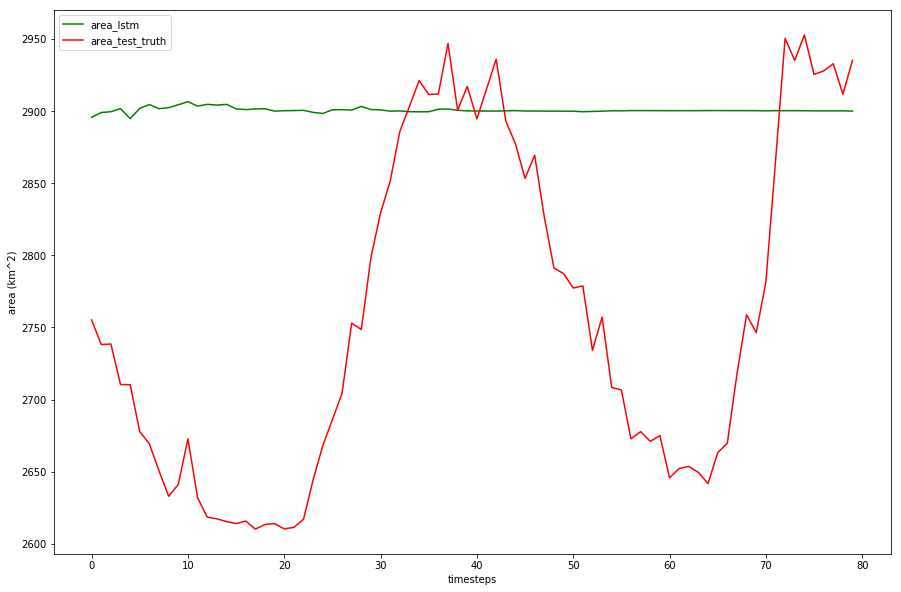

In [46]:
area_lstm = []
for boundary_vector in full_shape_predictions_multi_steps_0:
    area = calc_area(boundary_vector, region)
    area_lstm.append(area*0.25*0.25)
    
area_test_truth = []
for boundary_vector in data_test[:80]:
    area = calc_area(boundary_vector, region)
    area_test_truth.append(area*0.25*0.25)

fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.plot(area_lstm, color='green', label='area_lstm')
ax.plot(area_test_truth, color='r', label='area_test_truth')
ax.set_xlabel('timesteps')
ax.set_ylabel('area (km^2)')
ax.legend()
plt.savefig('visualize/area_groundtruth_lstm_2.png')